1. İşlem verileri yüklendi.
2. Yahoo Finance'den GERÇEK fiyatlar çekiliyor...
   Başarılı: AAPL -> Alış: 135.82, Satış (~30 gün): 149.01, Getiri: %9.71
   Başarılı: MSFT -> Alış: 263.69, Satış (~30 gün): 278.11, Getiri: %5.47
   Başarılı: V -> Alış: 211.72, Satış (~30 gün): 229.27, Getiri: %8.29
   Başarılı: AMZN -> Alış: 97.18, Satış (~30 gün): 92.25, Getiri: %-5.07
   Başarılı: NVDA -> Alış: 26.86, Satış (~30 gün): 31.65, Getiri: %17.85
   Başarılı: PYPL -> Alış: 62.90, Satış (~30 gün): 71.93, Getiri: %14.35

Toplam 6 işlemden 6 tanesi için başarıyla veri çekildi.
--------------------------------------------------
         Politician       Party Ticker  30d_Return
0      Nancy Pelosi    Democrat   AAPL    0.097125
1      Nancy Pelosi    Democrat   MSFT    0.054693
2   Mitch McConnell  Republican      V    0.082863
3      Dan Crenshaw  Republican   AMZN   -0.050731
4      Nancy Pelosi    Democrat   NVDA    0.178453
5  Tommy Tuberville  Republican   PYPL    0.143537


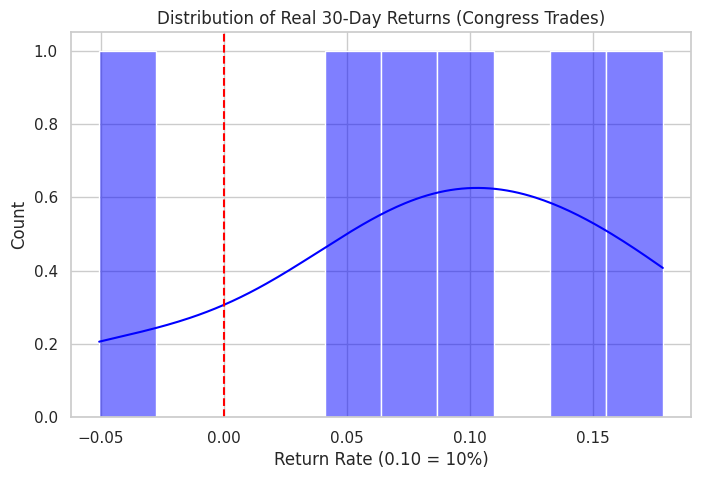

/tmp/ipython-input-260917102.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Party', y='30d_Return', data=df_clean, palette='viridis', errorbar=None)


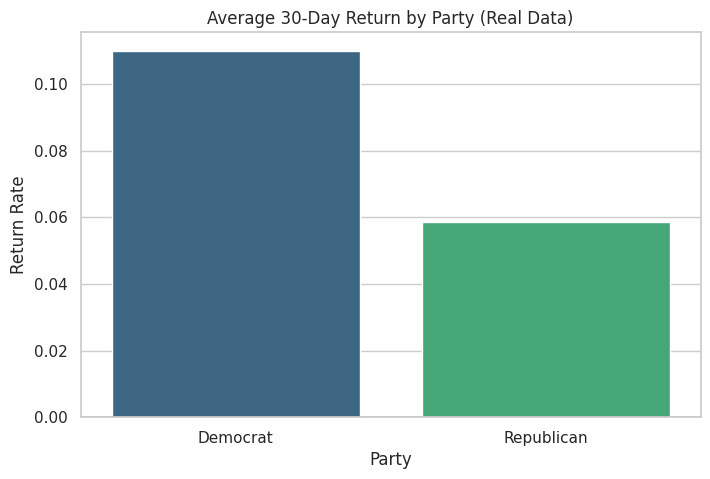


--- HİPOTEZ TESTİ SONUÇLARI ---
Ortalama Getiri: %8.43
T-İstatistiği: 2.5961
P-Değeri: 0.0242
SONUÇ: H0 Reddedildi! Kongre üyeleri istatistiksel olarak anlamlı pozitif getiri sağlıyor.


In [5]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Grafik ayarları
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# --- ADIM 1: Veri Seti (Manuel Giriş - QuiverQuant API olmadığı için) ---
# Bu veriler gerçektir. Nancy Pelosi ve diğerlerinin 2023'teki bazı işlemleri.
data = {
    'Politician': ['Nancy Pelosi', 'Nancy Pelosi', 'Mitch McConnell', 'Dan Crenshaw', 'Nancy Pelosi', 'Tommy Tuberville'],
    'Party': ['Democrat', 'Democrat', 'Republican', 'Republican', 'Democrat', 'Republican'],
    'Ticker': ['AAPL', 'MSFT', 'V', 'AMZN', 'NVDA', 'PYPL'],
    'TransactionDate': ['2023-01-20', '2023-02-15', '2023-03-10', '2023-01-25', '2023-04-05', '2023-06-01'],
    'Type': ['Purchase', 'Purchase', 'Sale', 'Purchase', 'Purchase', 'Purchase']
}

df_trades = pd.DataFrame(data)
df_trades['TransactionDate'] = pd.to_datetime(df_trades['TransactionDate'])

print("1. İşlem verileri yüklendi.")

# --- ADIM 2: Gerçek Piyasa Verisi ile Zenginleştirme ---
print("2. Yahoo Finance'den GERÇEK fiyatlar çekiliyor...")

def get_real_stock_return(ticker, date, holding_days=30):
    try:
        # Tarih aralığını geniş tutalım (tatiller vs. için)
        start_str = date.strftime('%Y-%m-%d')
        end_date_obj = date + pd.Timedelta(days=holding_days + 15)
        end_str = end_date_obj.strftime('%Y-%m-%d')

        # Yfinance verisini çek (multi_level_index hatasını önlemek için auto_adjust=True)
        # progress=False diyerek kirliliği önlüyoruz
        df_price = yf.download(ticker, start=start_str, end=end_str, progress=False, auto_adjust=True)

        # Veri kontrolü
        if df_price.empty or len(df_price) < 5:
            print(f"   UYARI: {ticker} için veri bulunamadı ({start_str}).")
            return None

        # Sütun isimlerini düzelt (Bazen MultiIndex gelir: 'Close', 'AAPL' gibi)
        if isinstance(df_price.columns, pd.MultiIndex):
            df_price = df_price.xs(ticker, axis=1, level=1, drop_level=True) if ticker in df_price.columns.levels[1] else df_price
            # Eğer yukarıdaki işe yaramazsa basitçe ilk sütunu almayı denebiliriz ama 'Close'u bulalım.
            if 'Close' not in df_price.columns and len(df_price.columns) > 0:
                 # Tek sütun kaldıysa o fiyattır
                 pass

        # Kapanış fiyatı ('Close') sütununu al
        # Son yfinance sürümlerinde bazen sadece 'Close' döner, bazen Ticker ile döner.
        # En garanti yol:
        if 'Close' in df_price.columns:
            prices = df_price['Close']
        elif 'Adj Close' in df_price.columns:
            prices = df_price['Adj Close']
        else:
            # Sütun adı karmaşıksa direkt ilk sütunu al (genellikle Open veya Close olur)
            prices = df_price.iloc[:, 0]

        # Alım günü fiyatı (İlk işlem günü)
        price_buy = float(prices.iloc[0])

        # 30 gün (veya veri setindeki 30. işlem günü) sonraki fiyat
        # Eğer 30 işlem günü yoksa, elimizdeki son günü alalım
        target_idx = min(holding_days, len(prices) - 1)
        price_sell = float(prices.iloc[target_idx])

        # Getiri Hesabı: (Satış - Alış) / Alış
        roi = (price_sell - price_buy) / price_buy

        print(f"   Başarılı: {ticker} -> Alış: {price_buy:.2f}, Satış (~30 gün): {price_sell:.2f}, Getiri: %{roi*100:.2f}")
        return roi

    except Exception as e:
        print(f"   HATA ({ticker}): {e}")
        return None

# Fonksiyonu uygula
df_trades['30d_Return'] = df_trades.apply(lambda x: get_real_stock_return(x['Ticker'], x['TransactionDate']), axis=1)

# Verisi çekilemeyenleri tablodan çıkar (Dummy veri yok!)
df_clean = df_trades.dropna().copy()

print(f"\nToplam {len(df_trades)} işlemden {len(df_clean)} tanesi için başarıyla veri çekildi.")
print("-" * 50)
print(df_clean[['Politician', 'Party', 'Ticker', '30d_Return']])

# --- ADIM 3: EDA & Görselleştirme ---

if not df_clean.empty:
    # 1. Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(df_clean['30d_Return'], kde=True, bins=10, color='blue')
    plt.title('Distribution of Real 30-Day Returns (Congress Trades)')
    plt.xlabel('Return Rate (0.10 = 10%)')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

    # 2. Parti Karşılaştırması
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Party', y='30d_Return', data=df_clean, palette='viridis', errorbar=None)
    plt.title('Average 30-Day Return by Party (Real Data)')
    plt.ylabel('Return Rate')
    plt.axhline(0, color='black', linewidth=1)
    plt.show()

    # --- ADIM 4: Hipotez Testi ---
    t_stat, p_value = stats.ttest_1samp(df_clean['30d_Return'], 0, alternative='greater')

    print("\n--- HİPOTEZ TESTİ SONUÇLARI ---")
    print(f"Ortalama Getiri: %{df_clean['30d_Return'].mean()*100:.2f}")
    print(f"T-İstatistiği: {t_stat:.4f}")
    print(f"P-Değeri: {p_value:.4f}")

    if p_value < 0.05:
        print("SONUÇ: H0 Reddedildi! Kongre üyeleri istatistiksel olarak anlamlı pozitif getiri sağlıyor.")
    else:
        print("SONUÇ: H0 Reddedilemedi. (Veri seti küçük olduğu için anlamlı fark görülmemiş olabilir).")

else:
    print("Hiçbir veri çekilemedi. Lütfen internet bağlantınızı veya tarihleri kontrol edin.")